<a href="https://colab.research.google.com/github/pedrogengo/cassava_disease_classification_OAKD/blob/master/CassavaClassificationPytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training and Conversion of a Cassava Disease Classifier for OAK-D

## 1. Creating the dataset

First, we will download the data, which is avaiable in our Google Drive. Next, we will unzip and mount the folders structure to use with pytorch's Dataloader.

In [ ]:
!gdown --id 13p1sL3oK0Nmsne1c7pkDClnknX0Eqm3_
!unzip drive/MyDrive/cassava-leaf-disease-classification.zip -d .
!rm -rf test_tfrecords/
!rm -rf train_tfrecords/
!rm -f train.csv
!rm -f label_num_to_disease_map.json
!rm -f sample_submission.csv
!mkdir cassava_disease
!mv train_images cassava_disease/train_images
!mv test_images cassava_disease/test_images
!rm cassava-leaf-disease-classification.zip

Next, we will download _train.csv_ and _test.csv_ which contains informatiom about the classes of our images and separates our images in train images and validation images.

In [ ]:
import pandas as pd
import os

In [ ]:
!gdown --id 1BTdb7RGNZhVlD5qqXnqPzhy9L9vq3CuP
!gdown --id 14efT_I3ZiDkMcrOX1PuzvqtDRANr2E_b
!mkdir cassava_disease/train
!mkdir cassava_disease/val

Traceback (most recent call last):
  File "/usr/local/bin/gdown", line 5, in <module>
    from gdown.cli import main
  File "/usr/local/lib/python2.7/dist-packages/gdown/__init__.py", line 3, in <module>
    import pkg_resources
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 36, in <module>
    import email.parser
  File "/usr/lib/python2.7/email/parser.py", line 12, in <module>
    from email.feedparser import FeedParser
  File "/usr/lib/python2.7/email/feedparser.py", line 27, in <module>
    from email import message
  File "/usr/lib/python2.7/email/message.py", line 16, in <module>
    import email.charset

Traceback (most recent call last):
  File "/usr/local/bin/gdown", line 5, in <module>
    from gdown.cli import main
  File "/usr/local/lib/python2.7/dist-packages/gdown/__init__.py", line 3, in <module>
    import pkg_resources
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 3251, in <module>
    @_call_aside
  Fi

In [ ]:
train_df = pd.read_csv('train.csv')
train_df

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-4c72703f4c6b>", line 1, in <module>
    train_df = pd.read_csv('train.csv')
  File "/usr/local/lib/python3.7/dist-packages/pandas/io/parsers.py", line 688, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/usr/local/lib/python3.7/dist-packages/pandas/io/parsers.py", line 454, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/usr/local/lib/python3.7/dist-packages/pandas/io/parsers.py", line 948, in __init__
    self._make_engine(self.engine)
  File "/usr/local/lib/python3.7/dist-packages/pandas/io/parsers.py", line 1180, in _make_engine
    self._engine = CParserWrapper(self.f, **self.options)
  File "/usr/local/lib/python3.7/dist-packages/pandas/io/parsers.py", line 2010, in __init__
    self._reader = parsers.TextReader(src, **kwds)
  File "

FileNotFoundError: ignored

In [ ]:
for index, row in train_df.iterrows():
  filename = row[0]
  class_ = row[2]
  try:
    os.mkdir(f"cassava_disease/train/{class_}")
  except:
    pass
  os.rename(f"cassava_disease/train_images/{filename}", f"cassava_disease/train/{class_}/{filename}")

In [ ]:
test_df = pd.read_csv('test.csv')
test_df

In [ ]:
for index, row in test_df.iterrows():
  filename = row[0]
  class_ = row[2]
  try:
    os.mkdir(f"cassava_disease/val/{class_}")
  except:
    pass
  os.rename(f"cassava_disease/train_images/{filename}", f"cassava_disease/val/{class_}/{filename}")

## 2. Model training

You can jump this step if you want and use the [available](link) trained model or another model you want.

This code was based on the pytorch example of transfer learning

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [ ]:
!rm -rf cassava_disease/train/.ipynb_checkpoints/
!rm -rf cassava_disease/val/.ipynb_checkpoints/
!rm -rf cassava_disease/.ipynb_checkpoints/

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=2, hue=0.05),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = 'cassava_disease'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


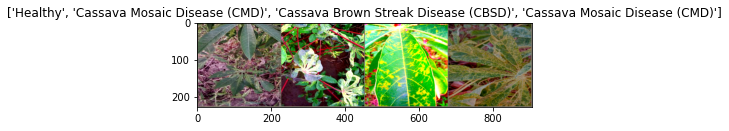

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print(outputs)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 5)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.00001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.5470 Acc: 0.3588
val Loss: 1.4969 Acc: 0.3797

Epoch 1/49
----------
train Loss: 1.4656 Acc: 0.3918
val Loss: 1.4011 Acc: 0.4103

Epoch 2/49
----------
train Loss: 1.4153 Acc: 0.4135
val Loss: 1.3289 Acc: 0.4371

Epoch 3/49
----------
train Loss: 1.3763 Acc: 0.4289
val Loss: 1.2855 Acc: 0.4687

Epoch 4/49
----------
train Loss: 1.3571 Acc: 0.4433
val Loss: 1.2508 Acc: 0.4767

Epoch 5/49
----------
train Loss: 1.3327 Acc: 0.4607
val Loss: 1.2277 Acc: 0.5007

Epoch 6/49
----------
train Loss: 1.3153 Acc: 0.4616
val Loss: 1.1877 Acc: 0.5195

Epoch 7/49
----------
train Loss: 1.3032 Acc: 0.4684
val Loss: 1.1865 Acc: 0.5092

Epoch 8/49
----------
train Loss: 1.3111 Acc: 0.4722
val Loss: 1.1835 Acc: 0.5294

Epoch 9/49
----------
train Loss: 1.3035 Acc: 0.4743
val Loss: 1.1825 Acc: 0.5252

Epoch 10/49
----------
train Loss: 1.2929 Acc: 0.4799
val Loss: 1.1701 Acc: 0.5271

Epoch 11/49
----------
train Loss: 1.3112 Acc: 0.4688
val Loss: 1.1761 Acc: 0.5219

Epoch 12/49
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([[ 2.3018,  1.9580, -0.1435, -0.3058, -0.2544],
        [-1.3325, -1.2728,  3.2297,  4.8093, -0.4863],
        [-1.4911,  0.1848,  2.2976,  2.1042,  0.0518],
        [ 3.2404,  0.6265,  0.6963, -0.2752,  0.2816]], device='cuda:0')


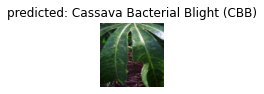

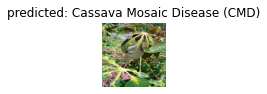

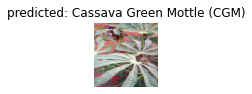

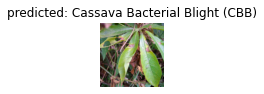

tensor([[-1.4334, -0.1141,  1.9081,  1.5121, -0.5934],
        [ 0.8268,  0.0845,  1.1304,  4.2565,  0.7447],
        [ 3.6039,  1.7385, -2.2858,  0.2291,  0.2798],
        [-2.0108,  0.4624,  5.8838,  1.6365, -0.4224]], device='cuda:0')


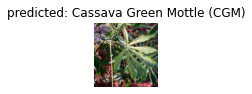

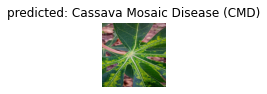

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [ ]:
input,_ = next(iter(dataloaders['train']))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
torch.onnx.export(model_conv.cpu(), (input, ), 'resnet18_brigth.onnx')

## 3. Converting to IR format

In [ ]:
!pip install openvino-dev[onnx,tensorflow2]==2021.4.* openvino

     |████████████████████████████████| 6.2 MB 7.1 MB/s 
     |████████████████████████████████| 28.2 MB 42 kB/s 
     |████████████████████████████████| 3.3 MB 63.0 MB/s 
     |████████████████████████████████| 3.3 MB 52.4 MB/s 
     |████████████████████████████████| 49.9 MB 15 kB/s 
     |████████████████████████████████| 508 kB 68.3 MB/s 
     |████████████████████████████████| 1.7 MB 50.6 MB/s 
     |████████████████████████████████| 76 kB 6.1 MB/s 
     |████████████████████████████████| 12.5 MB 16 kB/s 
     |████████████████████████████████| 25.9 MB 937 bytes/s 
     |████████████████████████████████| 636 kB 57.6 MB/s 
     |████████████████████████████████| 1.2 MB 51.0 MB/s 
     |████████████████████████████████| 99 kB 11.8 MB/s 
     |████████████████████████████████| 1.9 MB 64.4 MB/s 
     |████████████████████████████████| 3.0 MB 46.7 MB/s 
     |████████████████████████████████| 1.5 MB 59.9 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
     |██████████████

In [ ]:
import sys
import time
import os
from pathlib import Path

import cv2
import mo_onnx
import numpy as np
from openvino.inference_engine import IECore

In [ ]:
output_dir = os.path.join('IR_models', 'FP32')
model_name = 'resnet18_brigth.onnx'

In [ ]:
# Get the path to the Model Optimizer script
mo_path = str(Path(mo_onnx.__file__))

# Construct the command for Model Optimizer
mo_command = f""""{sys.executable}"
                 "{mo_path}"
                 --input_model "{model_name}"
                 --input_shape "[1,3,224,224]"
                 --mean_values="[123.675, 116.28 , 103.53]"
                 --scale_values="[58.395, 57.12 , 57.375]"
                 --data_type FP32
                 --output_dir "{output_dir}"
                 """
mo_command = " ".join(mo_command.split())
print("Model Optimizer command to convert the ONNX model to OpenVINO:")
print(mo_command)

Model Optimizer command to convert the ONNX model to OpenVINO:
"/usr/bin/python3" "/usr/local/lib/python3.7/dist-packages/mo_onnx.py" --input_model "resnet18_brigth.onnx" --input_shape "[1,3,224,224]" --mean_values="[123.675, 116.28 , 103.53]" --scale_values="[58.395, 57.12 , 57.375]" --data_type FP32 --output_dir "IR_models/FP32"


In [ ]:
!mkdir IR_models
!mkdir IR_models/FP32

mkdir: cannot create directory ‘IR_models’: File exists
mkdir: cannot create directory ‘IR_models/FP32’: File exists


In [ ]:
print("Exporting ONNX model to IR... This may take a few minutes.")
mo_result = %sx $mo_command
print("\n".join(mo_result))

Exporting ONNX model to IR... This may take a few minutes.
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/content/resnet18_brigth.onnx
	- Path for generated IR: 	/content/IR_models/FP32
	- IR output name: 	resnet18_brigth
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,3,224,224]
	- Mean values: 	[123.675, 116.28 , 103.53]
	- Scale values: 	[58.395, 57.12 , 57.375]
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	None
	- Reverse input channels: 	False
ONNX specific parameters:
	- Inference Engine found in: 	/usr/local/lib/python3.7/dist-packages/openvino
Inference Engine version: 	2021.4.0-3839-cd81789d294-releases/2021/4
Model Optimizer version: 	2021.4.0-3839-cd81789d294-relea

In [ ]:
image_filename = "cassava_disease/val/Healthy/1218759874.jpg"
image = cv2.cvtColor(cv2.imread(image_filename), cv2.COLOR_BGR2RGB)

resized_image = cv2.resize(image, (224, 224))

# Convert the resized images to network input shape
input_image = np.expand_dims(np.transpose(resized_image, (2, 0, 1)), 0)

In [ ]:
# Load network to Inference Engine
ie = IECore()
net_ir = ie.read_network(model=os.path.join(output_dir, model_name.split('.')[0] + '.xml'))
exec_net_ir = ie.load_network(network=net_ir, device_name="CPU")

# Get names of input and output layers
input_layer_ir = next(iter(exec_net_ir.input_info))
output_layer_ir = next(iter(exec_net_ir.outputs))

# Run the Inference on the Input image...
res_ir = exec_net_ir.infer(inputs={input_layer_ir: input_image})
res_ir = res_ir[output_layer_ir]

In [ ]:
["CBB",  "CBSD", "CGM", "CMD", "Healthy"][np.argmax(res_ir)]

'Healthy'

## 4. Coverting to .blob format

In [ ]:
print("This will take a while...")
!wget -O openvino_key https://apt.repos.intel.com/openvino/2021/GPG-PUB-KEY-INTEL-OPENVINO-2021?elq_cid=6770273_ts1607381885691&erpm_id=9830841_ts1607381885691&elq_cid=6770273_ts1607381960247&erpm_id=9830841_ts1607381960247 
!apt-key add openvino_key
#!apt-key -q list
!echo "deb https://apt.repos.intel.com/openvino/2021 all main" | tee /etc/apt/sources.list.d/intel-openvino-2021.list
!apt update -q
!apt-cache search intel-openvino-dev-ubuntu18
!apt-get install intel-openvino-dev-ubuntu18-2021.2.200 -y -q
!pip install -U --no-deps --quiet openvino

#unknown bug - this is just a patch
!cp /opt/intel/openvino_2021/deployment_tools/inference_engine/external/tbb/lib/libtbb.so /usr/lib/x86_64-linux-gnu/libtbb.so
!cp /opt/intel/openvino_2021/deployment_tools/inference_engine/external/tbb/lib/libtbb.so.2 /usr/lib/x86_64-linux-gnu/libtbb.so.2
!ldconfig
print("Installation Completed...")
#%env we can set environmental variable with this

#Run the validation
!ls /opt/intel/
#Run the Validation Demo code.
demo_cmd = "/opt/intel/openvino_2021/deployment_tools/demo/demo_squeezenet_download_convert_run.sh"
import os
import subprocess
import shutil
output = subprocess.check_output(demo_cmd, shell=True)
print (output.decode('utf-8')) 

This will take a while...
--2021-08-10 00:21:00--  https://apt.repos.intel.com/openvino/2021/GPG-PUB-KEY-INTEL-OPENVINO-2021?elq_cid=6770273_ts1607381885691
Resolving apt.repos.intel.com (apt.repos.intel.com)... 104.65.10.161, 2600:1406:3f:a90::4b23, 2600:1406:3f:a95::4b23
Connecting to apt.repos.intel.com (apt.repos.intel.com)|104.65.10.161|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 939 [binary/octet-stream]
Saving to: ‘openvino_key’

openvino_key        100%[===================>]     939  --.-KB/s    in 0s      

2021-08-10 00:21:00 (160 MB/s) - ‘openvino_key’ saved [939/939]

OK
deb https://apt.repos.intel.com/openvino/2021 all main
Get:1 https://apt.repos.intel.com/openvino/2021 all InRelease [5,659 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/

In [ ]:
!cp /opt/intel/openvino_2021.2.200/deployment_tools/inference_engine/lib/intel64/libmyriadPlugin.so /usr/lib/x86_64-linux-gnu/libmyriadPlugin.so
!source /opt/intel/openvino_2021/bin/setupvars.sh && /opt/intel/openvino_2021/deployment_tools/inference_engine/lib/intel64/myriad_compile -m /content/IR_models/FP32/resnet18_brigth.xml -ip U8 -VPU_NUMBER_OF_SHAVES 6 -VPU_NUMBER_OF_CMX_SLICES 6

[setupvars.sh] OpenVINO environment initialized
Inference Engine: 
	API version ............ 2.1
	Build .................. 2021.2.0-1877-176bdf51370-releases/2021/2
	Description ....... API
[Warning][VPU][Config] Deprecated option was used : VPU_MYRIAD_PLATFORM
Done



```
//#iamintel
//References: 
//COLAB for OpenVINO 
//https://colab.research.google.com/drive/1AwkhrLkjnmPDwTOGBlPSPs5FhycEr__d?authuser=1#scrollTo=V2iIEiRfjGBE
//Original Tensorflow Classification Tutorial:
//https://www.tensorflow.org/tutorials/images/classification
//First release: Jan 27, 2021
//Last update: March 30, 2021

#include <iostream>
using namespace std;

int main() {
    string author="Raymond Lo, PhD";
    string role="Intel OpenVINO Edge AI Evangelist";
    string linkedin="https://www.linkedin.com/in/raymondlo84/";

    cout << "Author:" << author << endl;
    cout << "Role:" << role << endl;
    cout << "LinkedIn: " << linkedin << endl;
    return 0; 
}

/**
  Except as otherwise noted, the content of this page is licensed 
  under the Creative Commons Attribution 4.0 License, and code
  samples are licensed under the Apache 2.0 License. 
**/

```

